Instalando condacolab

In [1]:
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/download/24.11.2-1_colab/Miniforge3-colab-24.11.2-1_colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:17
🔁 Restarting kernel...


In [1]:
import condacolab
condacolab.check()

✨🍰✨ Everything looks OK!


Instalando OpenMM e OpenMMTools

In [2]:
!mamba install -q cudatoolkit=11.6 openmm

Preparing transaction: ...working... done
Verifying transaction: ...working... done
Executing transaction: ...working... By downloading and using the CUDA Toolkit conda packages, you accept the terms and conditions of the CUDA End User License Agreement (EULA): https://docs.nvidia.com/cuda/eula/index.html

done


In [5]:
# Autor: Elvis do A. Soares
# Github: @elvissoares
from sys import stdout
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Integração Termodinâmica


In [6]:
from openmm.app import *
from openmm import *
from openmm.unit import *


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.11/dist-package

ImportError: numpy.core.multiarray failed to import (auto-generated because you didn't call 'numpy.import_array()' after cimporting numpy; use '<void>numpy._import_array' to disable if you are certain you don't need it).

Qual molécula iremos simular?

In [ ]:
my_molecule = 'methane'

Condição termodinâmica

In [ ]:
Temperatura = 298.15 * kelvin # Temperatura em Kelvin
Pressao = 1 * bar # Pressão em bar

NameError: name 'kelvin' is not defined

In [ ]:
pdb = PDBFile(f'{my_molecule}.pdb')

NameError: name 'PDBFile' is not defined

Escolhendo os arquivos de campo de força OPLS-AA gerados pelo LibParGen

In [ ]:
forcefield = ForceField(f'{my_molecule}.xml', 'tip3p.xml')
forcefield.setUseGeometricCombinationRule=True # OPLS-AA usa combinação geométrica

Cria a topolgia com moléculas de água ao redor (solvente)

In [ ]:
modeller = Modeller(pdb.topology, pdb.positions)

modeller.addSolvent(forcefield,model='tip3p', padding= 9.61 * angstroms)

PDBFile.writeFile(modeller.topology, modeller.positions, open(f'initial_{my_molecule}.pdb', 'w'))

In [ ]:
system = forcefield.createSystem(modeller.topology, nonbondedMethod=PME,
        nonbondedCutoff=8.5*angstroms, constraints=HBonds)

### Configuração do Sistema Alquímico

In [ ]:
!mamba install -q openmmtools

In [ ]:
# Add alchemical lambda control to methane atoms
from openmmtools import alchemy, states

solute_atoms = [atom.index for atom in modeller.topology.atoms() if atom.residue.name == "CH4"]
print("Solute atoms:", solute_atoms)

alchemical_region = alchemy.AlchemicalRegion(alchemical_atoms = solute_atoms)
solute_system = alchemy.AbsoluteAlchemicalFactory().create_alchemical_system(system, alchemical_region)

Warning on use of the timeseries module: If the inherent timescales of the system are long compared to those being analyzed, this statistical inefficiency may be an underestimate.  The estimate presumes the use of many statistically independent samples.  Tests should be performed to assess whether this condition is satisfied.   Be cautious in the interpretation of the data.

****** PyMBAR will use 64-bit JAX! *******
* JAX is currently set to 32-bit bitsize *
* which is its default.                  *
*                                        *
* PyMBAR requires 64-bit mode and WILL   *
* enable JAX's 64-bit mode when called.  *
*                                        *
* This MAY cause problems with other     *
* Uses of JAX in the same code.          *
******************************************



Solute atoms: [0, 1, 2, 3, 4]


In [ ]:
# Plataforma (GPU se disponível)
platform = Platform.getPlatformByName('CUDA')
# platform = Platform.getPlatformByName('CPU')

# Integrador
integrator = LangevinMiddleIntegrator(Temperatura, 1/picosecond, 2*femtoseconds)
simulation = Simulation(modeller.topology, solute_system, integrator, platform)

OpenMMException: Error loading CUDA module: CUDA_ERROR_UNSUPPORTED_PTX_VERSION (222)

In [ ]:
# below corresponds to fully interacting state
simulation.context.setParameter('lambda_electrostatics', 1.0)
simulation.context.setParameter('lambda_sterics', 1.0)

AttributeError: module 'openmm.app.simulation' has no attribute 'context'

In [ ]:
n_equil = 10000

simulation.context.setPositions(modeller.positions)
simulation.minimizeEnergy()

simulation.context.setVelocitiesToTemperature(Temperatura)

# Add a simple barostat for pressure control
# solute_system.addForce(MonteCarloBarostat(Pressao, Temperatura))

# Equilibration
simulation.step(n_equil)

initial_positions = simulation.context.getState(getPositions=True).getPositions()

### Loop de Integração Termodinâmica

In [ ]:
n_steps = 200
n_samples = 200

lambda_ele_grid = np.linspace(1.0, 0.0, 11)
U_mean_ele = np.zeros_like(lambda_ele_grid)
U_std_ele = np.zeros_like(lambda_ele_grid)

for i, l in enumerate(lambda_ele_grid):
    print('lambda:',l)

    simulation.context.setPositions(initial_positions)
    simulation.context.setParameter('lambda_electrostatics', l)

    simulation.step(n_equil)

    # Collect U_λ data
    U_lambda = []
    for iteration in range(n_samples):
        simulation.step(n_steps)
        e = simulation.context.getState(energy=True).getPotentialEnergy().value_in_unit(kilojoules_per_mole)
        U_lambda.append(e)
        # print(iteration,deriv)

    U_mean_ele[i] = np.mean(np.array(U_lambda))
    U_std_ele[i] = np.std(np.array(U_lambda))
    print(f"U_λ^ele: {U_mean_ele[i]:.4f} +- {U_std_ele[i]:.4f}")

lambda: 1.0
U_λ^ele: -8382.1644 +- 83.4567
lambda: 0.9
U_λ^ele: -8348.4396 +- 91.7172
lambda: 0.8
U_λ^ele: -8365.9705 +- 84.8845
lambda: 0.7
U_λ^ele: -8356.5477 +- 89.6752
lambda: 0.6
U_λ^ele: -8373.0959 +- 95.5431
lambda: 0.5
U_λ^ele: -8370.0362 +- 90.1355
lambda: 0.3999999999999999
U_λ^ele: -8400.3596 +- 82.7066
lambda: 0.29999999999999993
U_λ^ele: -8346.7968 +- 92.7799
lambda: 0.19999999999999996
U_λ^ele: -8342.6765 +- 88.9838
lambda: 0.09999999999999998
U_λ^ele: -8366.1694 +- 88.5918
lambda: 0.0
U_λ^ele: -8364.4624 +- 78.5891


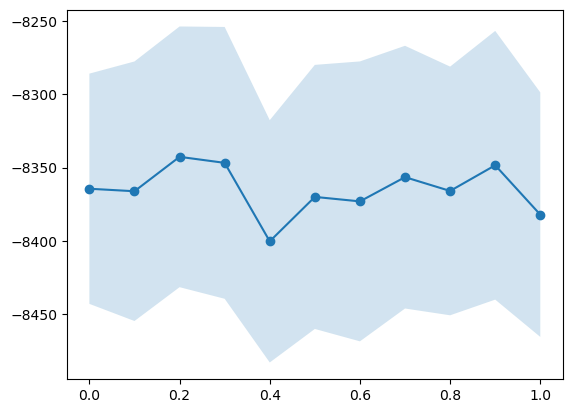

In [ ]:
plt.plot(lambda_ele_grid, U_mean_ele, marker='o', label='U_λ^ele')
plt.fill_between(lambda_ele_grid, U_mean_ele - U_std_ele, U_mean_ele + U_std_ele, alpha=0.2)

In [ ]:
lambda_steric_grid = np.linspace(1.0, 0.0, 11)
U_mean_steric = np.zeros_like(lambda_steric_grid)
U_std_steric = np.zeros_like(lambda_steric_grid)

for i, l in enumerate(lambda_steric_grid):
    print('lambda:',l)

    simulation.context.setPositions(initial_positions)
    simulation.context.setParameter('lambda_sterics', l)

    simulation.step(n_equil)

    # Collect U_λ data
    U_lambda = []
    for iteration in range(n_samples):
        simulation.step(n_steps)
        e = simulation.context.getState(energy=True).getPotentialEnergy().value_in_unit(kilojoules_per_mole)
        U_lambda.append(e)

    U_mean_steric[i] = np.mean(np.array(U_lambda))
    U_std_steric[i] = np.std(np.array(U_lambda))
    print(f"U_λ^ste: {U_mean_steric[i]:.4f} +- {U_std_steric[i]:.4f}")

lambda: 1.0
U_λ^ste: -8363.5172 +- 86.5862
lambda: 0.9
U_λ^ste: -8401.2395 +- 103.4985
lambda: 0.8
U_λ^ste: -8381.0536 +- 80.1024
lambda: 0.7
U_λ^ste: -8346.5092 +- 91.7799
lambda: 0.6
U_λ^ste: -8353.4846 +- 85.5091
lambda: 0.5
U_λ^ste: -8367.9574 +- 86.3918
lambda: 0.3999999999999999
U_λ^ste: -8352.2915 +- 78.4581
lambda: 0.29999999999999993
U_λ^ste: -8345.0604 +- 105.6097
lambda: 0.19999999999999996
U_λ^ste: -8352.9298 +- 84.2083
lambda: 0.09999999999999998
U_λ^ste: -8337.1902 +- 89.3851
lambda: 0.0
U_λ^ste: -8326.9071 +- 87.1799


<>:3: SyntaxWarning: invalid escape sequence '\l'
<>:3: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_167226/738208872.py:3: SyntaxWarning: invalid escape sequence '\l'
  plt.xlabel('$\lambda$')


Text(0, 0.5, 'U_λ (kJ/mol)')

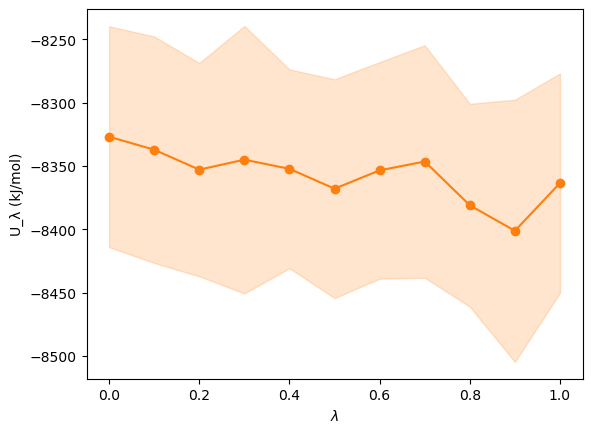

In [ ]:
plt.plot(lambda_steric_grid, U_mean_steric, marker='o', color='C1', label='U_λ^ste')
plt.fill_between(lambda_steric_grid, U_mean_steric - U_std_steric, U_mean_steric + U_std_steric, color='C1', alpha=0.2)
plt.xlabel('$\lambda$')
plt.ylabel('U_λ (kJ/mol)')

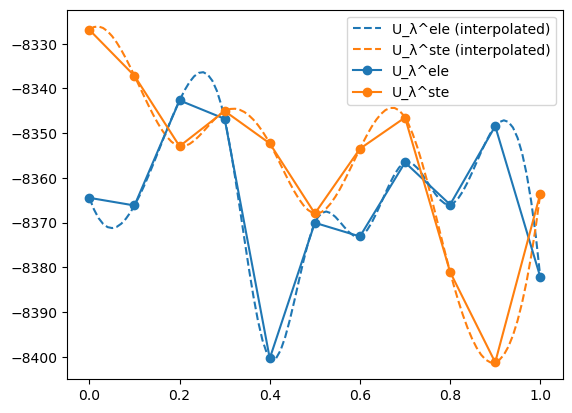

In [ ]:
# Interpolate U_λ with a smooth function and calculate the derivative
from scipy.interpolate import CubicSpline
interp_func_ele = CubicSpline(lambda_ele_grid[::-1], U_mean_ele[::-1])
interp_func_steric = CubicSpline(lambda_steric_grid[::-1], U_mean_steric[::-1])
lambda_grid = np.linspace(0.0, 1.0, 100)
U_ele = interp_func_ele(lambda_grid)
U_steric = interp_func_steric(lambda_grid)

plt.plot(lambda_grid, U_ele, label='U_λ^ele (interpolated)', linestyle='--')
plt.plot(lambda_grid, U_steric, label='U_λ^ste (interpolated)', linestyle='--')
plt.plot(lambda_ele_grid, U_mean_ele, marker='o',color='C0', label='U_λ^ele')
plt.plot(lambda_steric_grid, U_mean_steric, marker='o', color='C1', label='U_λ^ste')
plt.legend()

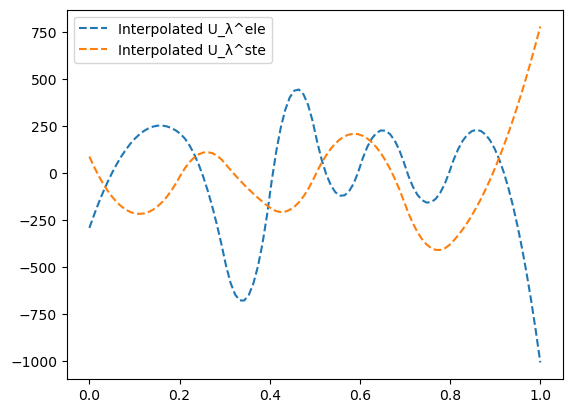

In [ ]:
# Calculate the derivatives of the interpolated functions
dU_ele_dlambda = interp_func_ele.derivative()(lambda_grid)
dU_steric_dlambda = interp_func_steric.derivative()(lambda_grid)

# Plot the interpolated U_λ
plt.plot(lambda_grid, dU_ele_dlambda, label='Interpolated U_λ^ele', linestyle='--')
plt.plot(lambda_grid, dU_steric_dlambda, label='Interpolated U_λ^ste', linestyle='--')
plt.legend()

In [ ]:
deltaG_ele = np.trapezoid(dU_ele_dlambda, lambda_grid)

print(f"ΔG_ele = {deltaG_ele:.3f} kJ/mol")

ΔG_ele = -17.911 kJ/mol


In [ ]:
deltaG_steric = np.trapezoid(dU_steric_dlambda, lambda_grid)

print(f"ΔG_steric = {deltaG_steric:.3f} kJ/mol")

ΔG_steric = -36.484 kJ/mol


In [ ]:
1.6e-19*(6.022e23) # conversão de Joules para kJ/mol

96352.0

In [ ]:
deltaG = deltaG_ele + deltaG_steric
print(f"ΔG_total = {deltaG:.3f} kJ/mol")
# Convert to eV
deltaG_eV = deltaG / 96.352
print(f"ΔG_total = {deltaG_eV:.3f} eV")

ΔG_total = -54.395 kJ/mol
ΔG_total = -0.565 eV


In [ ]:
3.4/40

0.08499999999999999

**<span style="color:#A03;font-size:14pt">
&#x270B; HANDS-ON! &#x1F528;
</span>**

> Faça uma estimativa do custo computacional (tempo de simulação) no seu _hardware_ atual para simulações longas da ordem de 1ns.
>